## Issue 838

Dataset               = 1
Method                = levmar
Statistic             = cstat
Initial fit statistic = 103.301
Final fit statistic   = 4.85918 at function evaluation 16
Data points           = 10
Degrees of freedom    = 8
Probability [Q-value] = 0.772516
Reduced statistic     = 0.607397
Change in statistic   = 98.4417
   bkg.c0         2.44444      +/- 0.524461    
   line.ampl      -15          +/- 0           


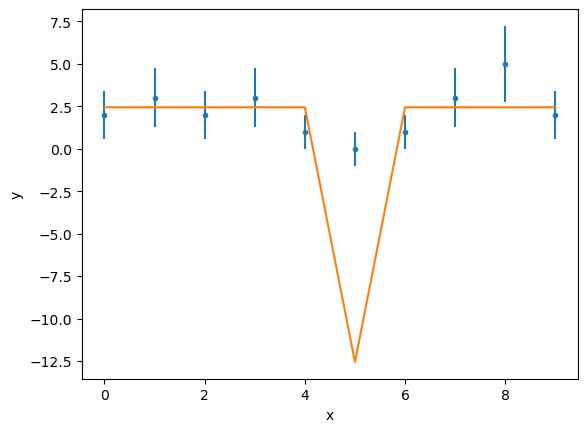

In [2]:
from sherpa.astro import ui
import numpy as np

ui.load_arrays(1, np.arange(10), np.array([2,3,2,3,1,0,1,3,5,2]), ui.Data1D)
ui.set_stat('cstat')
bkg = ui.const1d(name='bkg')
bkg.c0 = 0.1
line = ui.delta1d(name='line')
line.pos = 5.
line.pos.frozen = True
line.ampl = -15.
ui.set_source(bkg + line)


#ui.set_method('simplex')
ui.fit()

ui.plot_fit()

In [3]:
import numpy as np
import perfplot
from sherpa import stats

def setup_model(n):
    model = np.random.uniform(0.2, 10, n)
    data = np.random.poisson(np.maximum(model, 0))
    return (data, model)

cstat = stats.CStat()
cstatnumpy = stats.CStatNumpy()
cstatpenalty = stats.CStatNegativePenalty()

perfplot.show(
    setup=setup_model,
    kernels=[
        lambda data, model: cstat._calc(data, model, None, stats.truncation_value),
        lambda data, model: cstatnumpy._calc(data, model, None, stats.truncation_value),
        lambda data, model: cstatpenalty._calc(data, model, None, stats.truncation_value),
    ],
    labels=["C", "Numpy", "NumpyPenalty"],
    n_range=[2**k for k in range(1, 18)],  # 23
    xlabel="len(a)",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

ModuleNotFoundError: No module named 'perfplot'

In [ ]:
# Rewrite in OO
import numpy as np
from sherpa import data,models, fit, optmethods, stats


data = data.Data1D('data', np.arange(10), np.array([2,3,2,3,0,1,1,3,5,2]))

bkg = models.Const1D('bkg')
line = models.Delta1D('line')
line.pos = 5.
line.pos.frozen = True
source = bkg + line


In [ ]:
cstat = stats.CStat()
cstatpenalty = stats.CStatNegativePenalty(name='cstatpenalty')

amplgrid, c0grid = np.mgrid[-5: 4: .1, -3: 7: .1]
statgrid = np.zeros(c0grid.shape)
penaltygrid = np.zeros(c0grid.shape)
it = np.nditer(c0grid, flags=['multi_index'])
for x in it:
        bkg.c0 = c0grid[it.multi_index]
        line.ampl = amplgrid[it.multi_index]
        statgrid[it.multi_index] = cstat.calc_stat(data, source)[0]
        penaltygrid[it.multi_index] = cstatpenalty.calc_stat(data, source)[0]

AttributeError: module 'sherpa.stats' has no attribute 'CStatNegativePenalty'

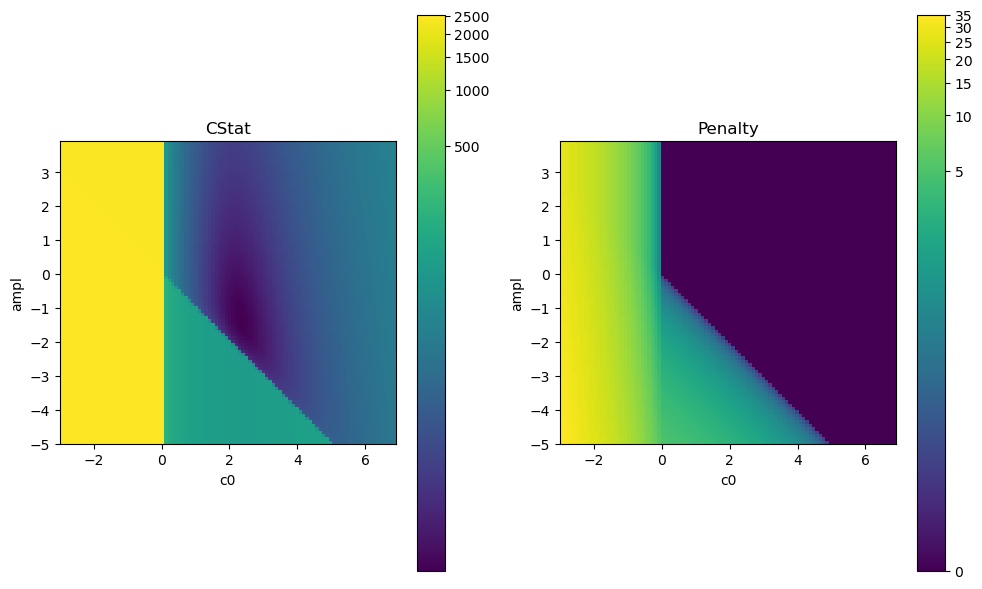

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

# Create an ImageNormalize object
norm = simple_norm(statgrid, 'log')
norm2 = simple_norm(penaltygrid - statgrid, 'log')


# Display the image
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))

im = axes[0].imshow(statgrid, origin='lower', norm=norm, 
               extent=[c0grid.min(), c0grid.max(), amplgrid.min(), amplgrid.max()])

im2 = axes[1].imshow(penaltygrid - statgrid, origin='lower', norm=norm2, 
               extent=[c0grid.min(), c0grid.max(), amplgrid.min(), amplgrid.max()])

fig.colorbar(im, ax=axes[0])
fig.colorbar(im2, ax=axes[1])

for ax in axes:
    ax.set_xlabel('c0')
    ax.set_ylabel('ampl')

axes[0].set_title('CStat')
axes[1].set_title('Penalty')
plt.tight_layout()


In [ ]:
def test_cstatpenalty(c0, ampl, opt=optmethods.NelderMead()):
    bkg.c0 = c0
    line.ampl = ampl
    fitter = fit.Fit(data=data, model=source, stat=cstat, method=opt)
    res = fitter.fit(record_steps=True)
    
    bkg.c0 = c0
    line.ampl = ampl
    fitter = fit.Fit(data=data, model=source, stat=cstatpenalty, method=opt)
    resp = fitter.fit(record_steps=True)
    
    return res.extra_output['record_steps'], resp.extra_output['record_steps']

In [ ]:
def plot_path(c0, ampl, opts = [optmethods.LevMar(), optmethods.NelderMead()]):

    fig, axes = plt.subplots(ncols=len(opts), figsize=(10, 6),
                             sharex=True, sharey=True)

    for ax in axes:
        ax.set_xlabel('ampl')
        ax.set_ylabel('c0')
        im = ax.imshow(statgrid, origin='lower', norm=norm, 
               extent=[c0grid.min(), c0grid.max(), amplgrid.min(), amplgrid.max()])

    for ax, o in zip(axes, opts):
        for p in test_cstatpenalty(c0=c0, ampl=ampl, opt=o):
            ax.plot(p['bkg.c0'], p['line.ampl'])
            ax.set_title(o.name)

        ax.set_xlim(c0grid.min(), c0grid.max())
        ax.set_ylim(amplgrid.min(), amplgrid.max())
        ax.set_xlabel('c0')
        ax.set_ylabel('ampl')

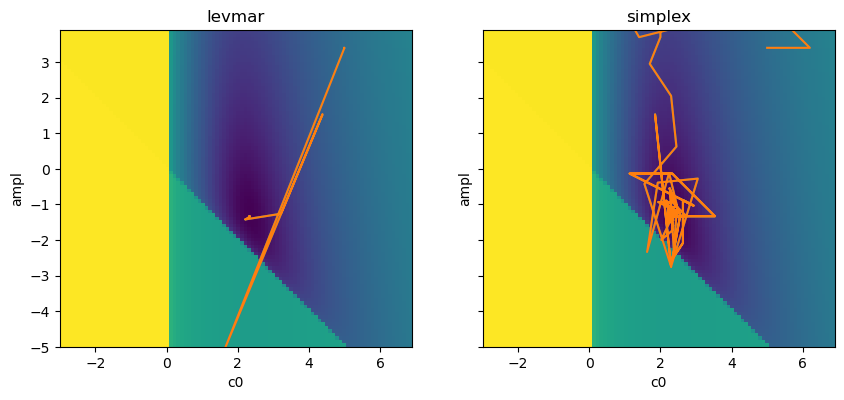

In [ ]:
plot_path(ampl=3.4,c0=5.)

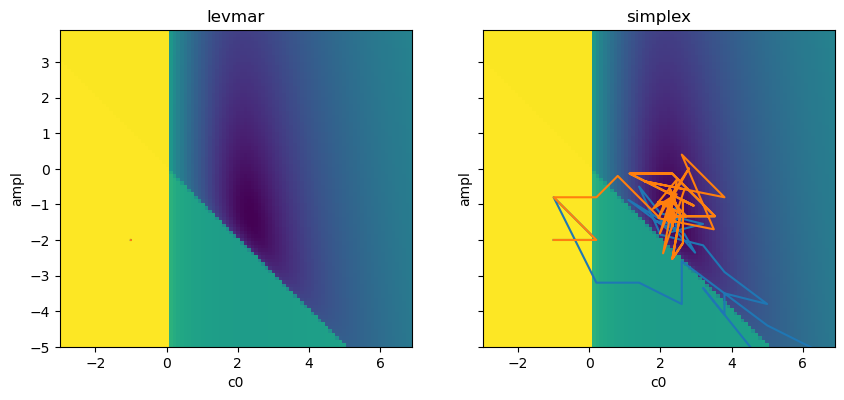

In [ ]:
plot_path(ampl=-2,c0=-1)

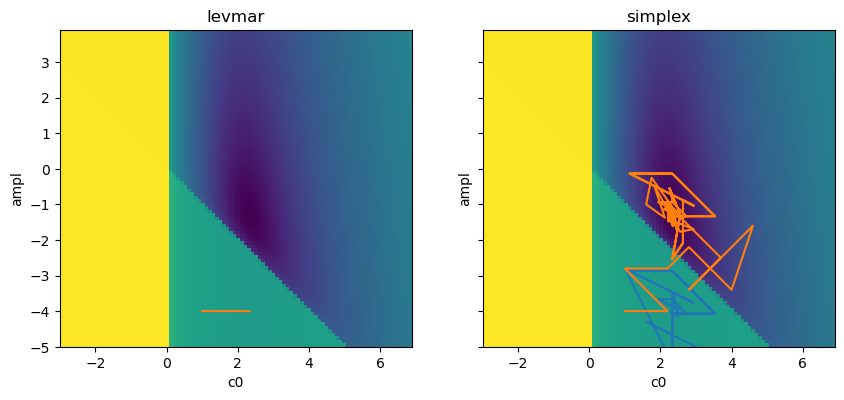

In [ ]:
plot_path(c0=1, ampl=-4)

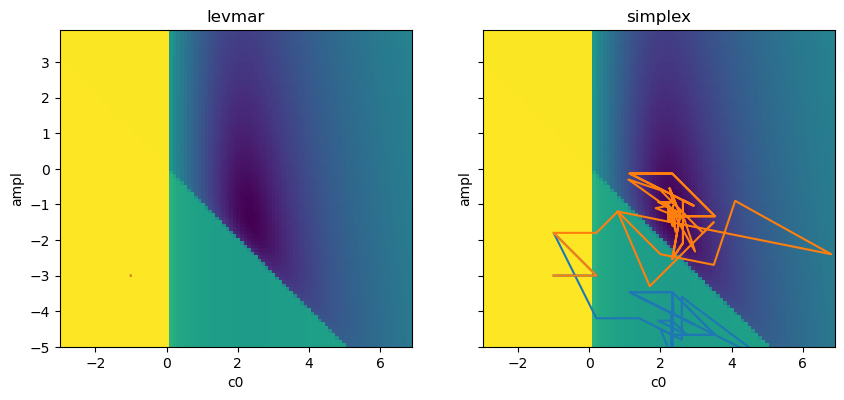

In [ ]:
plot_path(c0=-1, ampl=-3)

(-15.0, 5.0)

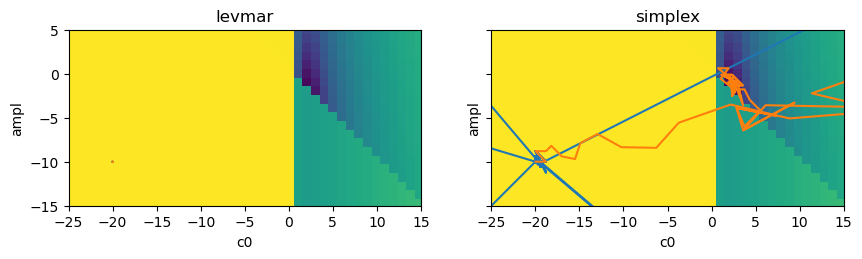

In [ ]:
amplgrid, c0grid = np.mgrid[-25: 25: 1, -25: 25: 1]
statgrid = np.zeros(c0grid.shape)
penaltygrid = np.zeros(c0grid.shape)
it = np.nditer(c0grid, flags=['multi_index'])
for x in it:
        bkg.c0 = c0grid[it.multi_index]
        line.ampl = amplgrid[it.multi_index]
        statgrid[it.multi_index] = cstat.calc_stat(data, source)[0]
        penaltygrid[it.multi_index] = cstatpenalty.calc_stat(data, source)[0]

plot_path(c0=-20, ampl=-10)
fig = plt.gcf()
fig.axes[0].set_xlim(-25, 15)
fig.axes[0].set_ylim(-15, 5)

In [ ]:
dd

AttributeError: module 'scipy.optimize' has no attribute 'asfeasdf'

In [ ]:
import numpy as np
from scipy.optimize import minimize
from sherpa import optmethods
from sherpa.utils.types import OptReturn, StatFunc
from sherpa.models.parameter import tinyval, hugeval

def scipy_minimize(fcn: StatFunc,
         x0: np.ndarray,
         xmin: np.ndarray,
         xmax: np.ndarray,
         method: None | str = None,
         tol: None | float = None,
         options: None | dict = None,
         ) -> OptReturn:
    
    if np.allclose(xmin, -hugeval) and np.allclose(xmax, hugeval):
        bounds = None
    else:
        bounds = [(None if pmin == -hugeval else pmin, 
                   None if pmax == hugeval else pmax) 
                  for pmin, pmax in zip(xmin, xmax)]

    result = minimize(fun = lambda x: fcn(x)[0], 
                      x0=x0,
                      # args=(), 
                      method=method, 
                      # jac=None, hess=None, hessp=None,
                      bounds=bounds,
                      # constraints=(), 
                      tol=tol,
                      #callback=None, 
                      options=options)
    result['input_bounds'] = bounds
    return (result.success, result.x, result.fun, result.message, result)

class Scipy(optmethods.OptMethod):
    def __init__(self, name: str = 'scipy') -> None:
        super().__init__(name=name, optfunc=scipy_minimize)




In [ ]:
import inspect
import functools
from collections.abc import Callable
from typing import Any
from textwrap import dedent

from scipy import optimize

import re

__all__ = []

# numpydoc.docscrape.NumpyDocString offers an easier interface, but
# we can extract this simple information without that dependency.
re_next_param_line = re.compile('^    [a-z]')
re_sphinx_ref = [re.compile(":[\w-]+:`[ \w<>()-.]+`"),
 re.compile(".. versionadded:: [\d.]+"), 
 re.compile(".. versionchanged:: [\d.]+"),
 re.compile(".. deprecated:: [\d.]+"),               
]

def extract_parameter_text_from_docstring(doc, par, cleanup=True):
    out = []
    good = False
    for l in doc.split('\n'):
        if good and re_next_param_line.match(l):
            break
        if l.startswith(f'    {par}'):
            good = True
        if good:
            if cleanup:
                out.append(re_sphinx_ref.sub("", l))
            else:
                out.append(l)
    out = dedent('\n'.join(out))
    return out

def convert_bounds_to_scipy(xmin, xmax):
    if np.allclose(xmin, -hugeval) and np.allclose(xmax, hugeval):
        return None
    else:
        return [(None if pmin == -hugeval else pmin, 
                 None if pmax == hugeval else pmax) 
                for pmin, pmax in zip(xmin, xmax)]

def wrap_scipy_fcn(func: Callable) -> Callable:
    """
    Wrap a function to be used with scipy.optimize.minimize
    """
    sig = inspect.signature(func)

    @functools.wraps(func)
    def fcn(fcn: StatFunc,
         x0: np.ndarray,
         xmin: np.ndarray,
         xmax: np.ndarray,
         **kwargs):

        converted_args = {}
        if 'x0' in sig.parameters.keys():
            converted_args['x0'] = x0
        if 'bounds' in sig.parameters.keys():
            converted_args['bounds'] = convert_bounds_to_scipy(xmin, xmax)
        if 'ranges' in sig.parameters.keys(): 
            # only in scipy.optimize.brute
            ranges = convert_bounds_to_scipy(xmin, xmax)
            if None in np.array(ranges):
                raise ValueError("Parameter min and max values must be set")
            
            converted_args['ranges'] = ranges

        result = func(lambda x: fcn(x)[0], **converted_args, **kwargs)
        for arg in ['bounds', 'ranges']:
            if arg in converted_args:
                result[f'input_{arg}'] = converted_args[arg]
        return (result.success, result.x, result.fun, result.message, result)
    return fcn

SCIPY_KEYWORDS_NOT_APPLICABLE = ['fun', 'fund',
                                 'args', 'x0', 'bounds', 'ranges',
                                 'jac', 'hess', 'hessp',
                                 'constraints']
'''List of keywords NOT to expose when wrapping scipy optimization functions.

This is a list of keywords in the signature of functions in scipy.optimize that we do not
want to expose, either because the interface converts Sherpa input to them
automatically, or because they are not applicable to the Sherpa interface.
'''

_DOCSTRING_TEMPLATE = """Interface to scipy.optimize.{cls.scipy_func.__name__}

This class wraps the scipy optimizer {cls.scipy_func.__name__} to match the calling
signature and return values to the Sherpa interface.

Some of the keywords in the signature of the scipy function are not
applicable to the Sherpa interface or are prefilled by Sherpa.
The following arguments are exposed as attributes of this class and 
can be changed. A short summary is below, but see the
`scipy.optimize.{cls.scipy_func.__name__}` documentation for details.

(The following text extracted from the docstring of the scipy function to ensure that it
matches the current scipy version, but it may contain unresolved references
and other formatting issues.)

Attributes
----------
"""

class ScipyBase(optmethods.OptMethod):
    """Base class for wrapping scipy optimization functions.
    This class wraps that function to match the calling signature and
    return values to the Sherpa interface.
    """

    scipy_func: Callable
    """Optimization function in scipy
    
    This class wraps that function to match the calling signature and
    return values to the Sherpa interface.
    """
    def __init_subclass__(cls, /, **kwargs):
        super().__init_subclass__(**kwargs)
        cls.__doc__ = _DOCSTRING_TEMPLATE.format(cls=cls)
        for p in cls._get_default_config(cls).keys():
            cls.__doc__ += f"{extract_parameter_text_from_docstring(cls.scipy_func.__doc__, p)}\n"

    def __init__(self, name: str = 'scipy.minimize') -> None:
        super().__init__(name=name, optfunc=wrap_scipy_fcn(self.scipy_func))

    def _get_default_config(self) -> dict[str, Any]:
        sig = inspect.signature(self.scipy_func)
        return {p.name: p.default for p in sig.parameters.values()
                if p.kind == p.POSITIONAL_OR_KEYWORD and
                 p.name not in SCIPY_KEYWORDS_NOT_APPLICABLE}

#class ScipyMinimize(ScipyBase):
#    def __init__(self, name: str = 'scipy.minimize') -> None:
#        super().__init__(name=name, optfunc=wrap_scipy_fcn(optimize.minimize))

# for f in [optimize.minimize, optimize.differential_evolution,
#          optimize.dual_annealing, optimize.basinhopping]:
myscipy = type('ScipyMinimize', (ScipyBase,), {'scipy_func': optimize.minimize})

In [ ]:
print(myscipy.__doc__)

Interface to scipy.optimize.minimize

This class wraps the scipy optimizer to match the calling signature and
return values to the Sherpa interface.

Some of the keywords in the signature of the scipy function are not
applicable to the Sherpa interface or are prefilled by Sherpa.
The following arguments are exposed as attributes of this class and 
can be changed. A short summary is below, but see the
`scipy.optimize.minimize` documentation for details.

Attributes
----------
method : str or callable, optional
    Type of solver.  Should be one of

    - 'Nelder-Mead' 
    - 'Powell'      
    - 'CG'          
    - 'BFGS'        
    - 'Newton-CG'   
    - 'L-BFGS-B'    
    - 'TNC'         
    - 'COBYLA'      
    - 'COBYQA'      
    - 'SLSQP'       
    - 'trust-constr'
    - 'dogleg'      
    - 'trust-ncg'   
    - 'trust-exact' 
    - 'trust-krylov' 
    - custom - a callable object, see below for description.

    If not given, chosen to be one of ``BFGS``, ``L-BFGS-B``, ``SLSQ

In [ ]:
optimize.minimize.__doc__.split('\n')[19]

'    x0 : ndarray, shape (n,)'

In [ ]:
re_next_param_line = re.compile('^    [a-z]')
re_sphinx_ref = re.compile(":ref:`[ \w<>()-.]+`")

def extract_parameter_text_from_docstring(doc, par, cleanup=True):
    out = []
    good = False
    for l in doc.split('\n'):
        if good and re_next_param_line.match(l):
            break
        if l.startswith(f'    {par}'):
            good = True
        if good:
            if cleanup:
                out.append(re_sphinx_ref.sub("", l))
            else:
                out.append(l)
    out = dedent('\n'.join(out))
    return out

In [ ]:
out = extract_parameter_text_from_docstring(optimize.minimize.__doc__, 'methodss')
print(out)

In [ ]:
re_sphinx_ref.sub("", "    - 'Powell'      :ref:`(see here) <optimize.minimize-powell>`")

"    - 'Powell'      "

In [ ]:
docs = optimize.minimize.__doc__.split('\n')
for line in docs:
    if line.startswith('    method'):
        print(line[4:])
    else:
        print(line)

ValueError: '    method' is not in list

In [ ]:
gaussian = models.Gauss1D('gaussian')
gaussian.pos.min = -np.inf

ParameterErr: parameter gaussian.pos has a hard minimum of -3.40282e+38

In [ ]:
print(optimize.minimize.__doc__)

Minimization of scalar function of one or more variables.

    Parameters
    ----------
    fun : callable
        The objective function to be minimized::

            fun(x, *args) -> float

        where ``x`` is a 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.

        Suppose the callable has signature ``f0(x, *my_args, **my_kwargs)``, where
        ``my_args`` and ``my_kwargs`` are required positional and keyword arguments.
        Rather than passing ``f0`` as the callable, wrap it to accept
        only ``x``; e.g., pass ``fun=lambda x: f0(x, *my_args, **my_kwargs)`` as the
        callable, where ``my_args`` (tuple) and ``my_kwargs`` (dict) have been
        gathered before invoking this function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where ``n`` is the number of independent variables.
    args : tuple, optional
        Extra argumen

In [ ]:
from sherpa.data import Data1D
from sherpa.stats import CStat
from sherpa.models import Const1D, Delta1D
from sherpa.fit import Fit
from sherpa.optmethods import NelderMead, LevMar

dat = Data1D('dat', np.arange(10), np.array([2,3,2,3,1,0,1,3,5,2]))
bkg = Const1D(name='bkg')
bkg.c0 = 3.4
line = Delta1D(name='line')
line.pos = 5.
line.pos.frozen = True
line.ampl = -1.2
model = bkg + line

fitter = Fit(data=dat, model=model, stat=CStat(), method=NelderMead())
fitter.fit()


Parameter,Best-fit value
bkg.c0,2.44444
line.ampl,-3.45939


In [ ]:
model.reset()
model

<BinaryOpModel model instance 'bkg + line'>

In [ ]:
method = Scipy()
method.method = 'CG'

In [ ]:
def test_bounds_correctly_converted(recwarn):
    """
    This test uses both a direct and an indirect way to check that
    bounds are set to `None` if they are really just numerical max/min
    of a floating point number.

    We perform a fit with the `CG` method, which does not support bounds and will
    raise a warning if any bounds are set. This tests that the bounds are actually
    passed in to scipy correctly. We also check the recoded bounds in the 
    extra_output field.
    """
    method = Scipy()
    method.method = 'CG'
    fitter = Fit(data=dat, model=model, stat=CStat(), method=method)
    fit_res = fitter.fit(record_steps=True)

    assert len(recwarn) == 0
    assert fit_res.extra_output['input_bounds'] is None

    # And while we are at it, check a few other things
    # These are regression test and might change if scipy changes the 
    # default behavior of the CG method.
    assert fit_res.success
    assert fit_res.nfev == 34
    assert np.allclose(fit_res.parvals, (2.444444465983341, -3.0014523573812197))


In [ ]:

fitter = Fit(data=dat, model=model, stat=CStat(), method=method)
fit_res = fitter.fit(record_steps=True)
fit_res

Parameter,Best-fit value
bkg.c0,2.44444
line.ampl,-3.00145


In [ ]:
fit_res.nfev

34

In [ ]:
fit_res.extra_output

      message: Optimization terminated successfully.
      success: True
       status: 0
          fun: 4.859179942114077
            x: [ 2.444e+00 -3.001e+00]
          nit: 5
          jac: [ 2.384e-07  0.000e+00]
         nfev: 34
         njev: 11
 input_bounds: None
 record_steps: [( 0,  1.194e+01,  3.400e+00, -1.200e+00)
                ( 1,  1.194e+01,  3.400e+00, -1.200e+00) ...
                (33,  4.859e+00,  2.444e+00, -3.001e+00)
                (34,  4.859e+00,  2.444e+00, -3.001e+00)]

In [ ]:
plot_path(c0=-20, ampl=-10, opts=[Scipy(), method, NelderMead()])
fig = plt.gcf()
fig.axes[0].set_xlim(-25, 15)
fig.axes[0].set_ylim(-15, 5)

NameError: name 'plot_path' is not defined

In [ ]:
cstat = stats.CStat()

amplgrid, c0grid = np.mgrid[-5: 4: .1, -3: 7: .1]
statgrid = np.zeros(c0grid.shape)
it = np.nditer(c0grid, flags=['multi_index'])
for x in it:
        bkg.c0 = c0grid[it.multi_index]
        line.ampl = amplgrid[it.multi_index]
        statgrid[it.multi_index] = cstat.calc_stat(data, source)[0]

In [ ]:
from matplotlib import pyplot as plt
from astropy.visualization import simple_norm

def plot_path(data, model, stat=cstat,
              opts = [optmethods.LevMar(), optmethods.NelderMead()]):

    fig, ax = plt.subplots(figsize=(10, 6),
                             sharex=True, sharey=True)
    norm = simple_norm(statgrid, 'log')
    
    im = ax.imshow(statgrid, origin='lower', norm=norm, 
               extent=[c0grid.min(), c0grid.max(), amplgrid.min(), amplgrid.max()])

    for o in opts:
        model.reset()
        print(model.thawedpars)
        fitter = fit.Fit(data=data, model=model, stat=stat, method=o)
        res = fitter.fit(record_steps=True)
        print(res.nfev)
        p = res.extra_output['record_steps']
        ax.plot(p['bkg.c0'], p['line.ampl'], label=o.name)
        ax.set_title(o.name)

        ax.set_xlim(c0grid.min(), c0grid.max())
        ax.set_ylim(amplgrid.min(), amplgrid.max())
        ax.set_xlabel('c0')
        ax.set_ylabel('ampl')
    fig.legend()
    return fig, ax

In [ ]:
bkg.c0 = 3.4
line.ampl = -1.2
model = bkg + line
model

In [ ]:
bkg.c0 = 0.1
line.ampl = 5.
model = bkg + line
model

<BinaryOpModel model instance 'bkg + line'>

In [ ]:
bkg.c0 = -1
line.ampl = -3
model = bkg + line
model

<BinaryOpModel model instance 'bkg + line'>

[-1.0, -3.0]
3
[-1.0, -3.0]
3
[-1.0, -3.0]
322
[-1.0, -3.0]
3


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'levmar'}, xlabel='c0', ylabel='ampl'>)

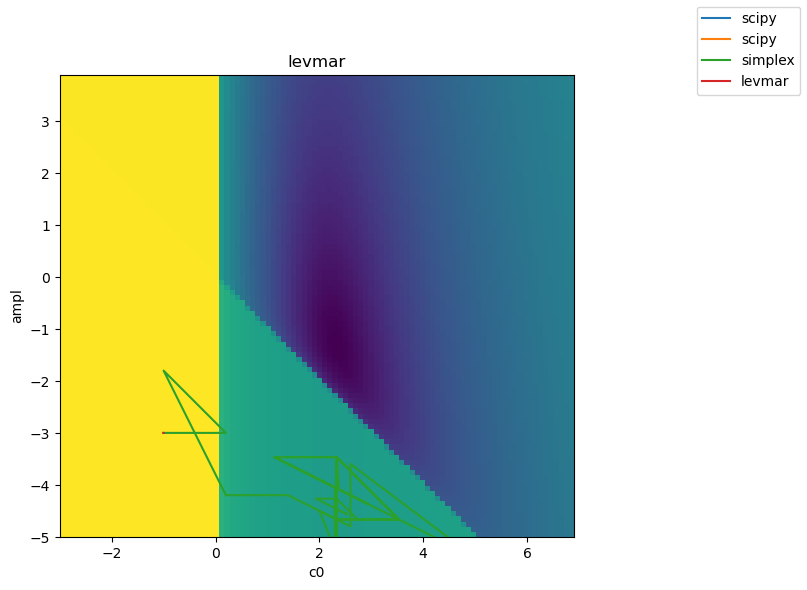

In [ ]:

plot_path(data, model, stat=cstat,
          opts=[Scipy(), method, NelderMead(), LevMar()])

In [ ]:
ui.load_pha('/Users/guenther//data/Chandra/HRZ_43/tgcat/obs_29077_tgid_6655/pha2.gz')

statistical errors were found in file '/Users/guenther//data/Chandra/HRZ_43/tgcat/obs_29077_tgid_6655/pha2.gz'
but not used; to use them, re-read with use_errors=True
read background file /Users/guenther/data/Chandra/HRZ_43/tgcat/obs_29077_tgid_6655/pha2_bg
read background_up into a dataset from file /Users/guenther//data/Chandra/HRZ_43/tgcat/obs_29077_tgid_6655/pha2.gz
read background_down into a dataset from file /Users/guenther//data/Chandra/HRZ_43/tgcat/obs_29077_tgid_6655/pha2.gz
Multiple data sets have been input: 1-2


In [ ]:
ui.load_arf(1, '/Users/guenther//data/Chandra/HRZ_43/tgcat/obs_29077_tgid_6655/leg_-1.arf.gz')
ui.load_rmf(1, '/Users/guenther//data/Chandra/HRZ_43/tgcat/obs_29077_tgid_6655/leg_-1.rmf.gz')
ui.load_arf(2, '/Users/guenther//data/Chandra/HRZ_43/tgcat/obs_29077_tgid_6655/leg_1.arf.gz')
ui.load_rmf(2, '/Users/guenther//data/Chandra/HRZ_43/tgcat/obs_29077_tgid_6655/leg_1.rmf.gz')


dataset 1: 0.0999973:0.800544 Energy (keV)
dataset 2: 0.0999973:0.800544 Energy (keV)
dataset 1: 0.0999973:0.800544 Energy (keV) (unchanged)
dataset 2: 0.0999973:0.800544 Energy (keV) (unchanged)
dataset 1: 0.0999973:0.800544 Energy (keV) (unchanged)
dataset 2: 0.0999973:0.800544 Energy (keV) (unchanged)


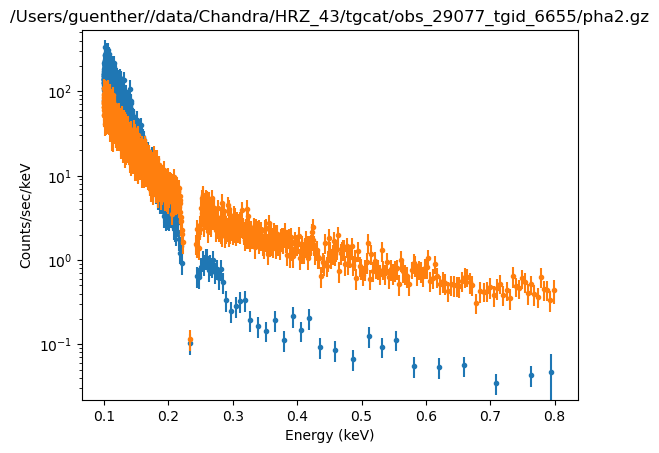

In [ ]:
ui.set_analysis('energy')
ui.notice(0.1, 0.8)
ui.group_counts(1, 20)
ui.group_counts(2, 20)
ui.plot_data(1, ylog=True)
ui.plot_bkg(1, overplot=True)

In [ ]:
b1 = ui.get_bkg(1)

In [ ]:
b1.backscal

10.0

In [ ]:
import sherpa

In [ ]:
from sherpa.astro import datastack
import os
from sherpa.astro.io import read_pha

In [ ]:
pha = read_pha(os.path.join(os.path.dirname(datastack.__file__), "tests", "data", "3c273.pi"))

statistical errors were found in file '/Users/guenther/code/sherpa/sherpa/astro/datastack/tests/data/3c273.pi'
but not used; to use them, re-read with use_errors=True
read ARF file /Users/guenther/code/sherpa/sherpa/astro/datastack/tests/data/3c273.arf
read RMF file /Users/guenther/code/sherpa/sherpa/astro/datastack/tests/data/3c273.rmf
statistical errors were found in file '/Users/guenther/code/sherpa/sherpa/astro/datastack/tests/data/3c273_bg.pi'
but not used; to use them, re-read with use_errors=True
read background file /Users/guenther/code/sherpa/sherpa/astro/datastack/tests/data/3c273_bg.pi


In [ ]:
from sherpa.astro.plot import DataPHAPlot

In [ ]:
print(pha)

None


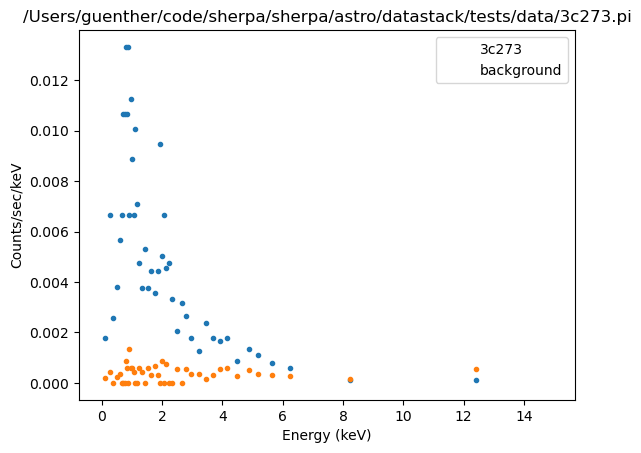

In [ ]:
plot3c = DataPHAPlot()
plot3c.prepare(pha)
plot3c.plot(label='3c273')

plot3c_bkg = DataPHAPlot()
plot3c_bkg.prepare(pha.get_background())
plot3c_bkg.plot(overplot=True, label='background')




In [ ]:
from astropy.table import Table

In [ ]:
tab = Table.read("https://content.cld.iop.org/journals/1538-3881/144/4/101/revision1/aj442275t2_mrt.txt", format='ascii')

/Users/guenther/mambaforge/envs/sherpaciao/lib/python3.11/site-packages/astropy/units/core.py:2145: UnitsWarning: '[10-7W]' did not parse as cds unit: Syntax error parsing unit '[10-7W]' If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)
/Users/guenther/mambaforge/envs/sherpaciao/lib/python3.11/site-packages/astropy/units/core.py:2145: UnitsWarning: '[10-7W]' did not parse as cds unit: Syntax error parsing unit '[10-7W]' If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)


In [ ]:
tab

ID,RAdeg,DEdeg,Class,NCts,FX,e_FX,NH,e_NH,kT,e_kT,Flux,e_Flux,logLX
,deg,deg,,ct,1e-07 ct / (s cm2),1e-07 ct / (s cm2),1e+22 / cm2,1e+22 / cm2,keV,keV,1e-15 mW / m2,1e-15 mW / m2,[10-7W]
int64,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,301.763336,27.482105,XYSO,61.5,30.75,7.74,0.6422,0.1766,4.2284,0.0028,7.849,1.36222,29.8855
2,301.766968,27.470575,XYSO,4.6,3.156,2.534,--,--,--,--,--,--,--
3,301.769287,27.482279,XYSO,23.6,10.28,4.152,10.4568,1.7627,0.7353,0.0508,4.5199,1.89773,31.6523
4,301.771271,27.48877,XYSO,25.5,13.88,5.29,1.1996,--,1.895,--,3.2439,--,29.7394
5,301.774353,27.483128,XYSO,23.7,13.465,4.87,--,--,--,--,--,--,--
6,301.774811,27.48609,XYSO,11.4,4.83,3.45,--,--,--,--,--,--,--
7,301.774902,27.483868,XYSO,17.5,6.926,3.372,--,--,--,--,--,--,--
8,301.775055,27.482403,XYSO,7.0,4.365,3.183,--,--,--,--,--,--,--


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

/var/folders/r7/f0qh27rn207bwwvt3s7v5gh40000gn/T/ipykernel_7277/1295425385.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(tab['FX']) - 7,
/var/folders/r7/f0qh27rn207bwwvt3s7v5gh40000gn/T/ipykernel_7277/1295425385.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(tab['FX']) - 7,


(array([18., 27., 26., 24., 24., 19., 12., 18., 12., 15., 19., 13.,  3.,
         2.,  5.,  3.,  0.,  0.,  3.,  1.,  1.,  0.,  0.,  0.]),
 array([-6.5, -6.4, -6.3, -6.2, -6.1, -6. , -5.9, -5.8, -5.7, -5.6, -5.5,
        -5.4, -5.3, -5.2, -5.1, -5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4,
        -4.3, -4.2, -4.1]),
 <BarContainer object of 24 artists>)

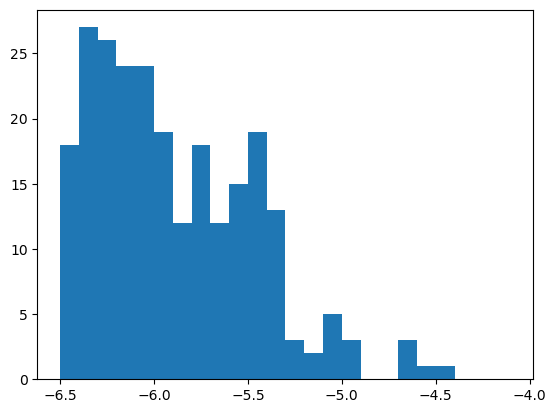

In [ ]:
plt.hist(np.log10(tab['FX']) - 7, 
         bins=np.arange(-6.5, -4., 0.1))

In [ ]:
import numpy as np
hist, edges = np.histogram(np.log10(tab['FX']) - 7,
                           bins=np.arange(-6.5, -4., 0.2))

NameError: name 'tab' is not defined

In [ ]:
hist

from sherpa.data import Data1DInt
from sherpa.models import Gauss1D
from sherpa.stats import CStat
from sherpa.optmethods import LevMar
from sherpa.fit import Fit
xrayflux = Data1DInt('xrayflux', edges[:-1], edges[1:], hist)
hist, edges = np.histogram(np.log10(tab['FX']) - 7,
                           bins=np.arange(-6.5, -4., 0.2))
import numpy as np
hist, edges = np.histogram(np.log10(tab['FX']) - 7,
                           bins=np.arange(-6.5, -4., 0.2))
hist


In [ ]:
edges

array([-6.5, -6.3, -6.1, -5.9, -5.7, -5.5, -5.3, -5.1, -4.9, -4.7, -4.5,
       -4.3, -4.1])

In [ ]:
len(hist), len(edges)

(12, 13)

In [ ]:
from sherpa.data import Data1DInt
from sherpa.models import Gauss1D
from sherpa.stats import CStat
from sherpa.optmethods import LevMar
from sherpa.fit import Fit

In [ ]:
xrayflux = Data1DInt('xrayflux', edges[:-1], edges[1:], hist)

NameError: name 'edges' is not defined

In [18]:
    >>> import numpy as np
    >>> from sherpa.data import Data1DInt
    >>> from sherpa.models import Gauss1D
    >>> from sherpa.stats import CStat
    >>> from sherpa.optmethods import LevMar
    >>> from sherpa.fit import Fit
    >>> 
    >>> hist = np.array([45, 50, 43, 30, 27, 32,  5,  8,  0,  4,  1,  0])
    >>> edges = np.array([-6.5, -6.3, -6.1, -5.9, -5.7, -5.5, -5.3, -5.1, -4.9, -4.7, -4.5,
    ...    -4.3, -4.1])
    >>> xrayflux = Data1DInt('xrayflux', edges[:-1], edges[1:], hist)

In [19]:
xraydist = Gauss1D('xraydist')
xfit = Fit(data=xrayflux, model=xraydist, stat=CStat(), method=LevMar())


In [20]:
xfit.guess()
print(xfit.fit())

datasets       = None
itermethodname = none
methodname     = levmar
statname       = cstat
succeeded      = True
parnames       = ('xraydist.fwhm', 'xraydist.pos', 'xraydist.ampl')
parvals        = (1.502103404881948, -6.254572554858249, 235.94188464394244)
statval        = 24.122296228170086
istatval       = 60.989781628740936
dstatval       = 36.86748540057085
numpoints      = 12
dof            = 9
qval           = 0.004112093257497959
rstat          = 2.6802551364633427
message        = successful termination
nfev           = 25


In [21]:
from sherpa.plot import Data1Plot

ImportError: cannot import name 'Data1Plot' from 'sherpa.plot' (/Users/guenther/code/sherpa/sherpa/plot/__init__.py)

In [ ]:
print(1)

1


In [22]:
from sherpa.models import Gauss1D
line1 = Gauss1D('line1')
line1.pos = 6716
line1.fwhm = 2
line1.ampl = 0.5
line2 = Gauss1D('line2')
line2.pos = 6731
line2.fwhm = 2
line2.ampl = 1

In [23]:
    >>> import numpy as np
    >>> wave_order26 = np.arange(6686, 6720, 0.5)
    >>> wave_order27 = np.arange(6705, 6735, 0.6)
    >>> rng = np.random.default_rng()
    >>> # Flux is normalized to 1, but not exactly right
    >>> flux_order26 = rng.normal(0.98, 0.1, size=len(wave_order26))
    >>> flux_order26 += line1(wave_order26)
    >>> flux_order27 = rng.normal(1.11, 0.1, size=len(wave_order27))
    >>> flux_order27 += line1(wave_order27) + line2(wave_order27)

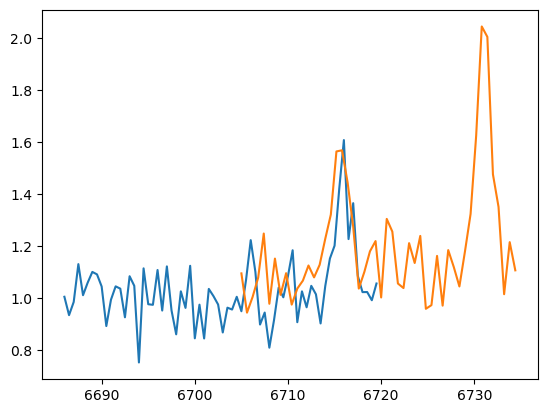

In [24]:
import matplotlib.pyplot as plt

plt.plot(wave_order26, flux_order26)
plt.plot(wave_order27, flux_order27)

In [ ]:
from sherpa.models import Const1D, Gauss1D

In [ ]:
line1 = Gauss1D('line1')
line1.pos = 6716
line1.fwhm = 2
line1.ampl = 0.5
line2 = Gauss1D('line2')
line2.pos = 6731
line2.fwhm = 2
line2.ampl = 1

In [ ]:
from sherpa.models import Const1D, Gauss1D
s_ii_6716 = Gauss1D('s_ii_6716')
s_ii_6716.pos = 6716
s_ii_6716.fwhm = 1.
s_ii_6716.ampl = 1.
s_ii_6731 = Gauss1D('s_ii_6731')
s_ii_6731.pos = 6731.
s_ii_6731.fwhm = s_ii_6716.fwhm
s_ii_6731.ampl = 1.
cont = Const1D('cont')
extra_cont_order27 = Const1D('extra_cont_order27')
model_26 = cont + s_ii_6716 + s_ii_6731
model_27 = cont + extra_cont_order27 + s_ii_6716 + s_ii_6731

In [ ]:
from sherpa.data import Data1D
import numpy as np
flux_err_26 = 0.1 * np.ones_like(flux_order26)
flux_err_27 = 0.1 * np.ones_like(flux_order27)
data_26 = Data1D('order26', wave_order26, flux_order26, staterror=flux_err_26)
data_27 = Data1D('order27', wave_order27, flux_order27, staterror=flux_err_27)


In [ ]:
from sherpa.data import DataSimulFit
from sherpa.models import SimulFitModel
from sherpa.stats import Chi2, Cash
from sherpa.optmethods import LevMar
from sherpa.fit import Fit
from sherpa.optmethods.optoptimagic import Optimagic

In [ ]:


data = DataSimulFit(name='both orders', datasets=(data_26, data_27))
model = SimulFitModel(name='both', parts=(model_26, model_27))

opt = Optimagic()
opt.algorithm="scipy_bfgs"
opt.scaling = True

fit = Fit(data, model, method=opt, stat=Cash())
result = fit.fit()

/var/folders/r7/f0qh27rn207bwwvt3s7v5gh40000gn/T/ipykernel_51154/4212729545.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


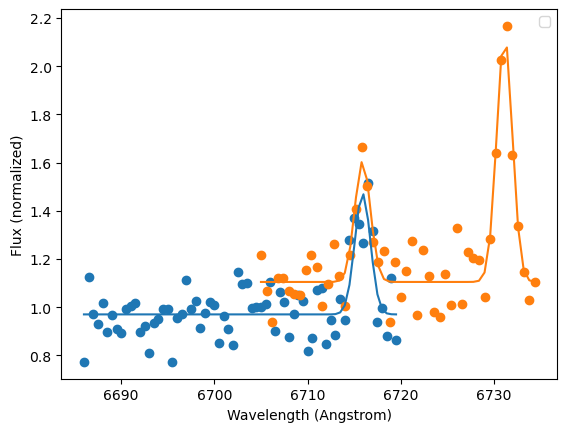

In [ ]:
plt.plot(wave_order26, flux_order26, 'o')
plt.plot(wave_order27, flux_order27, 'o')
plt.plot(wave_order26, model_26(wave_order26), color='C0')
plt.plot(wave_order27, model_27(wave_order27), color='C1')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (normalized)')
plt.legend()

In [ ]:
result

Parameter,Best-fit value
cont.c0,0.970442
s_ii_6716.fwhm,1.97713
s_ii_6716.pos,6715.91
s_ii_6716.ampl,0.501301
s_ii_6731.pos,6731.14
s_ii_6731.ampl,1.01968
extra_cont_order27.c0,0.134638


In [ ]:
result.extra_output['optimagic result'].n_fun_evals

In [ ]:
import optimagaic as om

In [ ]:
om.Bounds()

optimagic.parameters.bounds.Bounds

In [ ]:
import numpy as np

In [ ]:
om.mark.least_squares

<function optimagic.mark.least_squares(func: ~VectorFuncT) -> ~VectorFuncT>

In [ ]:
@om.mark.least_squares
def f(x):
    return np.sum((x - 1)**2)

def f2(x):
    return np.sum((x - 1)**2)

f3 = om.mark.least_squares(f2)

f, f3

(<function __main__.f(x)>, <function __main__.f2(x)>)

In [ ]:
f._problem_type

<AggregationLevel.LEAST_SQUARES: 'least_squares'>

In [ ]:
import numpy as np


import optimagic as om

In [ ]:
def sphere(params):
    return params @ params

In [ ]:
lbfgsb_res = om.minimize(
    fun=sphere,
    params=np.arange(5),
    algorithm="scipy_bfgs"
)


In [ ]:
lbfgsb_res.jac is None

True

In [ ]:
lbfgsb_res.nfev

4

In [ ]:
pass params when creating optmize object

SyntaxError: invalid syntax (4239228252.py, line 1)

In [ ]:
lmopt = LevMar(factor=20)
lmopt.default_config

TypeError: LevMar.__init__() got an unexpected keyword argument 'factor'

In [ ]:
import optimagic as om
om.algos.LeastSquares.AllNames

['nag_dfols',
 'pounders',
 'scipy_ls_dogbox',
 'scipy_ls_lm',
 'scipy_ls_trf',
 'tao_pounders',
 'tranquilo_ls']

In [ ]:
om.algos.Likelihood.AllNames

['bhhh']

In [ ]:
om.algos.scipy_differential_evolution.algo_info.supports_bounds

True

In [ ]:
print(om.algos.scipy_powell.algo_info)

AlgoInfo(name='scipy_powell', solver_type=<AggregationLevel.SCALAR: 'scalar'>, is_available=True, is_global=False, needs_jac=False, needs_hess=False, supports_parallelism=False, supports_bounds=True, supports_linear_constraints=False, supports_nonlinear_constraints=False, disable_history=False)


In [ ]:
algo = "scipy_lbfgsb"

In [ ]:
a = getattr(om.algos, algo)

In [ ]:
import optimagic as om
from optimagic.typing import AggregationLevel
a.algo_info.solver_type == AggregationLevel.LI

True

<Optimagic optimization method instance 'optimagic.minimize'>

In [ ]:
getattr(om.algos,'adf')

AttributeError: 'Algorithms' object has no attribute 'adf'

In [ ]:
Cash().calc_stat(data, model)

(231.14777148326795,
 array([0.034183  , 0.19346786, 0.14872552, 0.02876037, 0.07680445,
        0.04839613, 0.13840753, 0.20337092, 0.01739407, 0.1665451 ,
        0.04671266, 0.0475295 , 0.17125253, 0.25017723, 0.14689046,
        0.00334564, 0.0093195 , 0.04975827, 0.06860653, 0.0327197 ,
        0.10594656, 0.13695085, 0.14421531, 0.1021688 , 0.12380698,
        0.00530603, 0.0797637 , 0.04159113, 0.08319275, 0.14709013,
        0.07839567, 0.00346261, 0.02674769, 0.03130854, 0.05588466,
        0.05157279, 0.11421366, 0.03181453, 0.09857975, 0.04965252,
        0.03429271, 0.04165433, 0.10454641, 0.01772058, 0.18632189,
        0.01252556, 0.03455492, 0.15181342, 0.11646966, 0.0332525 ,
        0.06316531, 0.13158695, 0.06035177, 0.08292146, 0.17944704,
        0.12962832, 0.03421819, 0.02375849, 0.10767964, 0.04764958,
        0.04802484, 0.00177889, 0.00603695, 0.07573452, 0.04354339,
        0.06770333, 0.0137344 , 0.01734276, 0.13318944, 0.17084471,
        0.1991628 , 0.06633

In [ ]:
cont.c0 = 1
Cash().calc_stat(data, model)

(231.24271361850992,
 array([0.00425447, 0.22223976, 0.11823169, 0.05837373, 0.10617494,
        0.01839688, 0.1079642 , 0.17261093, 0.01245072, 0.1954563 ,
        0.01672178, 0.07704822, 0.20013942, 0.21919099, 0.11640561,
        0.03308666, 0.02048494, 0.07926573, 0.03850701, 0.00279846,
        0.07566265, 0.16601435, 0.1732415 , 0.07190349, 0.15293785,
        0.02447832, 0.10911917, 0.01162571, 0.11253079, 0.11660429,
        0.10775808, 0.03320305, 0.05637118, 0.00139433, 0.02584822,
        0.02155776, 0.1433936 , 0.00189779, 0.12783948, 0.07916051,
        0.0638782 , 0.0116886 , 0.13377572, 0.04738946, 0.21513084,
        0.04222053, 0.00462453, 0.12130449, 0.08613398, 0.06284324,
        0.03309276, 0.16067794, 0.03029351, 0.11225751, 0.20826665,
        0.09938268, 0.06321538, 0.05171908, 0.13362289, 0.07227311,
        0.02373614, 0.02648455, 0.03226636, 0.04743207, 0.01422207,
        0.03777603, 0.01606194, 0.01249776, 0.10468826, 0.14218135,
        0.17037804, 0.03812

In [ ]:
a = om.algorithms.ScipyLBFGSB()

In [ ]:
a.algo_info

AlgoInfo(name='scipy_lbfgsb', solver_type=<AggregationLevel.SCALAR: 'scalar'>, is_available=True, is_global=False, needs_jac=True, needs_hess=False, supports_parallelism=False, supports_bounds=True, supports_linear_constraints=False, supports_nonlinear_constraints=False, disable_history=False)

In [ ]:
a = 'asdf'

In [ ]:
hasattr(a, 'algo_info')

False

In [ ]:
type(om.algorithms.BHHH())

om.algos.bhhh

In [ ]:
        >>> import numpy as np
        >>> from sherpa.data import Data1D
        >>> from sherpa.models import Const1D, Gauss1D
        >>> from sherpa.stats import Chi2
        >>> from sherpa.optmethods import Optimagic
        >>> from sherpa.fit import Fit
        >>> data = Data1D('data1', x=np.arange(10),
        ...              y=[34.5, 23.4, 22.3, 45.6, 56.7, 67.8, 58.9, 43.0, 30.1, 25.2],
        ...              staterror=5 * np.ones(10))
        >>> const = Const1D(name='const')
        >>> gauss = Gauss1D(name='gauss')
        >>> gauss.pos = 5.0  # start not too far from the data
        >>> model = const + gauss
        >>> optimizer = Optimagic()

        >>> optimizer.algorithm = 'scipy_bfgs'
        >>> fit = Fit(data=data, model=model, stat=Chi2(), method=optimizer)
        >>> result = fit.fit()
        >>> print(result)

datasets       = None
itermethodname = none
methodname     = optimagic
statname       = chi2
succeeded      = True
parnames       = ('const.c0', 'gauss.fwhm', 'gauss.pos', 'gauss.ampl')
parvals        = (26.067327420836456, 3.285600683850382, 5.042514578467134, 42.005725690386164)
statval        = 6.879954370635533
istatval       = 700.2311623262916
dstatval       = 693.351207955656
numpoints      = 10
dof            = 6
qval           = 0.33209186143330294
rstat          = 1.1466590617725887
message        = Optimization terminated successfully.
nfev           = None


In [ ]:
omr = result.extra_output['optimagic result']

In [ ]:
import optimagic as om
om.OptimizeResult

optimagic.optimization.optimize_result.OptimizeResult

In [ ]:
omr.convergence_report

{'one_step': {'relative_criterion_change': 1.3409259347417734e-12,
  'relative_params_change': 1.5751893586209195e-07,
  'absolute_criterion_change': 9.2255092454252e-12,
  'absolute_params_change': 1.2578997199492016e-06},
 'five_steps': {'relative_criterion_change': 0.00044802722082809587,
  'relative_params_change': 0.0025520339599334517,
  'absolute_criterion_change': 0.003082406836099949,
  'absolute_params_change': 0.041909631395145426}}

In [ ]:
result.extra_output['optimagic result'].convergence_report['five_steps']

{'relative_criterion_change': 0.00044802722082809587,
 'relative_params_change': 0.0025520339599334517,
 'absolute_criterion_change': 0.003082406836099949,
 'absolute_params_change': 0.041909631395145426}

In [ ]:
Callable[[Callable[[Sequence[float] | ndarray[Any, Any], VarArg(Any), KwArg(Any)], tuple[float, ndarray[Any, Any]]], ndarray[Any, Any], ndarray[Any, Any], ndarray[Any, Any], KwArg(Any)], tuple[bool, ndarray[Any, Any], float, str, dict[str, Any]]]
Callable[[Callable[[Sequence[float] | ndarray[Any, Any], VarArg(Any), KwArg(Any)], tuple[float, ndarray[Any, Any]]], Sequence[float] | ndarray[Any, Any], Sequence[float] | ndarray[Any, Any], Sequence[float] | ndarray[Any, Any], VarArg(Any), KwArg(Any)], tuple[bool, ndarray[Any, Any], float, str, dict[str, Any]]]

In [ ]:
import numpy as np
rng = np.random.default_rng()
x = np.arange(10)
y = rng.poisson(lam = 5, size=10)

from sherpa.data import Data1D
from sherpa.models import Const1D
from sherpa.stats import Cash
from sherpa.optmethods import LevMar, Optimagic
from sherpa.fit import Fit

data = Data1D('data', x, y)
model = Const1D('const')
model.c0 = 1
opt = Optimagic()
opt.algorithm = 'scipy_bfgs'
fit = Fit(data=data, model=model, stat=Cash(), method=opt)
result = fit.fit()
result

Parameter,Best-fit value
const.c0,5.8


In [ ]:
y.mean()

5.8

In [ ]:
model.reset()
fit2 = Fit(data=data, model=model, stat=Cash(), method=LevMar())
fit2.fit()

Parameter,Best-fit value,Approximate error
const.c0,5.79999,± 0.763967


In [ ]:
from sherpa.optmethods import Scipy_Direct, Scipy_Basinhopping

In [ ]:
dr = Scipy_Direct()
bh = Scipy_Basinhopping()

In [ ]:
dr._get_default_config()

{}

In [ ]:
bh._get_default_config()

{'niter': 100,
 'T': 1.0,
 'stepsize': 0.5,
 'minimizer_kwargs': None,
 'take_step': None,
 'accept_test': None,
 'callback': None,
 'interval': 50,
 'disp': False,
 'niter_success': None,
 'rng': None}

In [ ]:
import scipy
scipy.__version__

'1.15.3'

In [ ]:
from scipy import optimize
import inspect

In [ ]:
sig = inspect.signature(optimize.direct)

In [ ]:
{p.name: p.default for p in sig.parameters.values()}

{'func': inspect._empty,
 'bounds': inspect._empty,
 'args': (),
 'eps': 0.0001,
 'maxfun': None,
 'maxiter': 1000,
 'locally_biased': True,
 'f_min': -inf,
 'f_min_rtol': 0.0001,
 'vol_tol': 1e-16,
 'len_tol': 1e-06,
 'callback': None}

In [ ]:
sig.parameters['maxiter'].kind

<_ParameterKind.KEYWORD_ONLY: 3>

In [ ]:
from sherpa.astro import ui

ui.clean()
ui.set_stat('wstat')
ui.load_data('src.pha')

ui.ignore()
ui.notice(0.3, 10)

m1 = ui.xsphabs.abs1 * ui.powlaw1d.p1

abs1.nh = 0.03
ui.freeze(abs1.nh)

ui.set_source(1, m1)
ui.save('session.sherpa', clobber=True)
ui.restore('session.sherpa')

In [2]:
import numpy as np
from sherpa.astro import ui

ui.load_arrays(1, np.arange(10), np.array([2,3,2,3,1,0,1,3,5,2]), ui.Data1D)
m1 = ui.xsphabs.abs1 * ui.powlaw1d.p1

ui.set_source(1, m1)
ui.save('session.sherpa', clobber=True)
ui.restore('session.sherpa')

 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996


In [1]:
import numpy as np
from sherpa import ui

ui.load_arrays(1, np.arange(10), np.array([2,3,2,3,1,0,1,3,5,2]), ui.Data1D)
m1 = ui.const1d.abs1 * ui.powlaw1d.p1

ui.set_source(1, m1)
ui.save('session.sherpa', clobber=True)
ui.restore('session.sherpa')

AttributeError: 'BinaryOpModel' object has no attribute 'parts'

In [1]:
import numpy as np
from sherpa.astro import ui

ui.load_arrays(1, np.arange(10), np.array([2,3,2,3,1,0,1,3,5,2]), ui.Data1D)
m1 = ui.xsphabs.abs1 * ui.powlaw1d.p1

ui.set_source(1, m1)
ui.save('session.sherpa', clobber=True)
ui.restore('session.sherpa')
m2 = ui.get_model(1)

 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996


In [2]:
m1

<BinaryOpModel model instance 'xsphabs.abs1 * powlaw1d.p1'>

In [3]:
m2

<BinaryOpModel model instance 'xsphabs.abs1 * powlaw1d.p1'>

In [5]:
m1.name

'xsphabs.abs1 * powlaw1d.p1'

In [2]:
import pickle
with open('session.sherpa', 'rb') as fin:
            obj = pickle.load(fin)

In [7]:
from sherpa.astro import xspec

In [8]:
m1 = xspec.XSphabs() * xspec.XSvapec()

In [1]:
from sherpa.models import Const1D, PowLaw1D

In [5]:
    
    from sherpa.ui.utils import Session
    outfile = "sherpa.save"
    session = Session()
    m1 = Const1D() + PowLaw1D()
    session.set_source(2, m1)
    session.save(str(outfile), clobber=True)
    session.clean()
    assert set() == set(session.list_model_ids())

    session.restore(str(outfile))
    assert {2, } == set(session.list_model_ids())
    assert m1.name == session.get_source(2).name

In [6]:
from sherpa.models import model
print(model.__file__)

/Users/guenther/code/sherpa/sherpa/models/model.py


In [1]:
from sherpa.optmethods.optfcts import lmdif, minim, montecarlo, neldermead

In [3]:
montecarlo

<function sherpa.optmethods.optfcts.montecarlo(fcn: collections.abc.Callable[typing.Concatenate[collections.abc.Sequence[float] | numpy.ndarray, ~P], tuple[float, numpy.ndarray]], x0: collections.abc.Sequence[float] | numpy.ndarray, xmin: collections.abc.Sequence[float] | numpy.ndarray, xmax: collections.abc.Sequence[float] | numpy.ndarray, ftol: <class 'SupportsFloat'> = 1.1920928955078125e-07, maxfev: int | None = None, verbose: int = 0, seed: int = 74815, population_size: int | None = None, xprob: float = 0.9, weighting_factor: float = 0.8, numcores: int = 1, rng: numpy.random._generator.Generator | numpy.random.mtrand.RandomState | None = None) -> tuple[bool, numpy.ndarray, float, str, dict[str, typing.Any]]>

In [4]:
import numpy as np
import pytest
from sherpa.optmethods import GridSearch, LevMar, MonCar, NelderMead
from sherpa.optmethods.opt import SimplexRandom

In [5]:
cls = NelderMead

In [6]:
    opt = cls()
    # Unlike test_optmethod_getattr, only check one config value
    oldval = opt.config["ftol"]
    assert opt.ftol == pytest.approx(oldval)

    newval = 0.01
    opt = cls(ftol=newval)
    assert opt.config["ftol"] == pytest.approx(newval)
    assert opt.ftol == pytest.approx(newval)

    # just to check that ftol doesn't happen to match the new value,
    # which would mean changing newval
    #
    assert oldval != pytest.approx(newval)

In [7]:
opt2 = cls()

In [8]:
opt2.config["ftol"]

1.1920928955078125e-07

In [1]:
1.96098192899 / 1.961205974015885

0.9998857616033944

In [10]:
from sherpa.stats import CStat
from sherpa.tests.test_fit_unit import fit_cstat, setup_stat_single, NelderMead, LevMar
import pytest

stat, usestat, usesys, finalstat = (CStat, True, True, fit_cstat)

In [13]:
    statobj = stat()
    fit = setup_stat_single(statobj, usestat, usesys)
    fit.method = LevMar()
    fr = fit.fit()
    fr.statval

1.9609819287041914

In [17]:
    statobj = stat()
    fit = setup_stat_single(statobj, usestat, usesys)
    fit.method = NelderMead()
    fit.method.ftol = 1e-4
    fr = fit.fit()
    fr.statval

1.96098365658851

In [9]:
fr.statval

1.9609819287041914

In [35]:
import numpy as np
edges = np.asarray([-10, -5, 5, 12, 17, 20, 30, 56, 60])
y = np.asarray([28, 62, 17, 4, 2, 4, 125, 55])
from sherpa.data import Data1DInt
d = Data1DInt('example histogram', edges[:-1], edges[1:], y)

from sherpa.models.basic import Const1D, Gauss1D
mdl = Const1D('base') - Gauss1D('line')
mdl.pars[0].val = 10
mdl.pars[1].val = 25
mdl.pars[2].val = 22
mdl.pars[3].val = 10

from sherpa.optmethods import NelderMead
from sherpa.stats import Cash
from sherpa.fit import Fit
f = Fit(d, mdl, stat=Cash(), method=NelderMead())
fit_res = f.fit()
from sherpa.plot import DataPlot
dplot = DataPlot()
dplot.prepare(d)

from sherpa.plot import ModelPlot
mplot = ModelPlot()
mplot.prepare(d, mdl)
from sherpa.plot import FitPlot
fplot = FitPlot()
fplot.prepare(dplot, mplot)
fplot.plot()


from sherpa.plot import TemporaryPlottingBackend, set_backend
set_backend('BasicBackend')


In [36]:
fplot

In [37]:
1.961205974015885/1.96098192899

1.000114251448508

In [38]:
d

<Data1DInt data set instance 'example histogram'>

In [39]:
from sherpa.plot import backend

In [43]:
set_backend('pylab')
import sherpa.plot as shplot
shplot.backend

In [67]:
pl = (d, {'color': 'r'})
col = [pl]
row = [col]

ip = [row]

# For simplification: If we get a tuple, we add the outer brackets automatically?
# How do we encode shared axes?

In [73]:
d.set_ylabel('y [units]')

In [74]:
ip

[[[(<Data1DInt data set instance 'example histogram'>, {'color': 'r'})]]]

In [75]:
from sherpa.data import Data1D, Data1DInt, Data2D, Data2DInt
def display_plot(data, **kwargs):
   match data:
       case Data1D():
           b.plot(data.x, data.y, xlabel=data.get_xlabel(), ylabel=data.get_ylabel(), **kwargs)
       case Data1DInt():
           b.histo(data.xlo, data.xhi, data.y, xlabel=data.get_xlabel(), ylabel=data.get_ylabel(), **kwargs)
       case _:
           raise TypeError(f"Unsupported data type: {type(data)}")


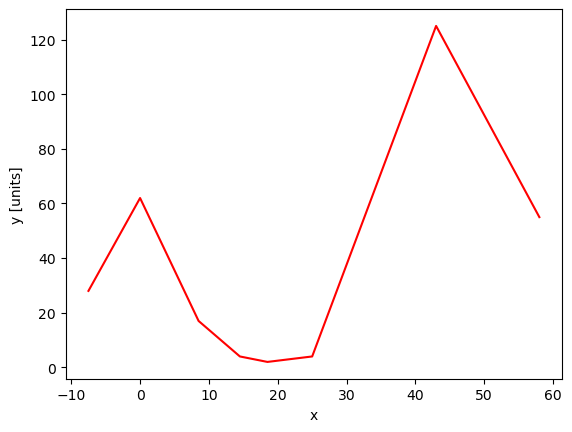

In [76]:
b = shplot.backend

# ip : intermediate plot representation - rename to better name
global_pref = {'top': 0, 'ratio': 2}

b.clear_window()
for irow, row in enumerate(ip):
    for icol, col in enumerate(row):
        # skip if None - what is all are None? Check? Empty plot? Leave ot backend?
        #b.set_jointplot(irow, icol, len(ip), len(row), create=True,
        #              top=global_pref.get('top', 0), ratio=global_pref.get('ratio', 2))
        b.set_subplot(irow, icol, len(ip), len(row), clearaxes=False)
        for ilayer, layer in enumerate(col):
            display_plot(layer[0], overplot=ilayer > 0, **layer[1])

In [72]:
d.get_xlabel()

'x'

In [77]:
d.to_plot()

(array([-7.5,  0. ,  8.5, 14.5, 18.5, 25. , 43. , 58. ]),
 array([ 28,  62,  17,   4,   2,   4, 125,  55]),
 None,
 array([ 2.5,  5. ,  3.5,  2.5,  1.5,  5. , 13. ,  2. ]),
 'x',
 'y [units]')

In [3]:
1.961205974015885/1.96098192899 - 1

0.00011425144850796265

In [2]:
import numpy as np

def make_range_sequence(npar: int,
                        xmin: np.ndarray,
                        xmax: np.ndarray,
                        N: int
                        ) -> list[list[float]]:
    """Create the grid ranges.

    Parameters
    ----------
    npar
       The number of parameters.
    xmin, xmax
       The minimum and maximum of each parameter.
    N
       The number of bins to create for each parameter.

    Returns
    -------
    grid
       Each element is a list of the parameter values at the
       grid point. There will be pow(N, npar) elements.

    Notes
    -----

    The ordering of the results (does the first parameter loop fastest
    or slowest) is not guaranteed.

    Examples
    --------

    Create the grid for 1 parameter, between 1 and 10,
    with 4 elements:

    >>> x1 = make_range_sequence(1, [1], [10], 4)
    >>> len(x1)
    4
    >>> x1[0]
    [np.float64(1.0)]
    >>> x1[1]
    [np.float64(4.0)]
    >>> x1[3]
    [np.float64(10.0)]

    With two parameters, ranging 1 to 10 and 100 to 115,
    N=4 created 16 pairs:

    >>> x2 = make_range_sequence(2, [1, 100], [10, 115], 4)
    >>> x2[0]
    [np.float64(1.0), np.float64(100.0)]
    >>> x2[1]
    [np.float64(1.0), np.float64(105.0)]
    >>> x2[2]
    [np.float64(1.0), np.float64(110.0)]
    >>> x2[3]
    [np.float64(1.0), np.float64(115.0)]
    >>> x2[4]
    [np.float64(4.0), np.float64(100.0)]

    """

    step = complex(N)
    slices = [slice(x1, x2, step)
              for x1, x2 in zip(xmin, xmax)]

    mgrid = np.mgrid[slices]
    mynfev = pow(N, npar)
    grid = list(map(np.ravel, mgrid))
    sequence = []
    for index in range(mynfev):
        tmp = []
        for xx in range(npar):
            tmp.append(grid[xx][index])
        sequence.append(tmp)

    return sequence

In [15]:
make_range_sequence(2, [1, 5], [2, 6], 4)

[[1.0, 5.0],
 [1.0, 5.333333333333333],
 [1.0, 5.666666666666667],
 [1.0, 6.0],
 [1.3333333333333333, 5.0],
 [1.3333333333333333, 5.333333333333333],
 [1.3333333333333333, 5.666666666666667],
 [1.3333333333333333, 6.0],
 [1.6666666666666665, 5.0],
 [1.6666666666666665, 5.333333333333333],
 [1.6666666666666665, 5.666666666666667],
 [1.6666666666666665, 6.0],
 [2.0, 5.0],
 [2.0, 5.333333333333333],
 [2.0, 5.666666666666667],
 [2.0, 6.0]]

In [4]:
complex(4)

(4+0j)

In [38]:
lin = np.linspace([1, 5], [2, 6], 4)
sequence = np.array(np.meshgrid(*lin.T)).T.reshape(-1, 2)

for s in sequence:
    print(s)


[1. 5.]
[1.         5.33333333]
[1.         5.66666667]
[1. 6.]
[1.33333333 5.        ]
[1.33333333 5.33333333]
[1.33333333 5.66666667]
[1.33333333 6.        ]
[1.66666667 5.        ]
[1.66666667 5.33333333]
[1.66666667 5.66666667]
[1.66666667 6.        ]
[2. 5.]
[2.         5.33333333]
[2.         5.66666667]
[2. 6.]


In [14]:
a = np.meshgrid(np.linspace([1, 5], [2, 6], 4))
a

[array([1.        , 5.        , 1.33333333, 5.33333333, 1.66666667,
        5.66666667, 2.        , 6.        ])]

In [40]:
pars = [1,2,3,4]
idx = 2

keep_pars = np.ones_like(pars)
keep_pars[idx] = 0
keep_idx = np.where(keep_pars)

keep_idx

(array([0, 1, 3]),)

In [44]:
np.delete(np.arange(len(pars)), idx)

array([0, 1, 3])

In [45]:
~np.isin(np.arange(len(pars)), idx)

array([ True,  True, False,  True])

In [46]:
from sherpa import data, models, stats, fit, plot
g1 = models.Gauss1D('g1')
g2 = models.Gauss1D('g2')
mdl = g1 + g2

In [51]:
type(mdl.thawedpars[4])

numpy.float64

In [52]:
dict(map(reversed,enumerate(mdl.get_thawed_pars())))


{<Parameter 'fwhm' of model 'g1'>: 0,
 <Parameter 'pos' of model 'g1'>: 1,
 <Parameter 'ampl' of model 'g1'>: 2,
 <Parameter 'fwhm' of model 'g2'>: 3,
 <Parameter 'pos' of model 'g2'>: 4,
 <Parameter 'ampl' of model 'g2'>: 5}

In [53]:
mdl.get_thawed_pars()

[<Parameter 'fwhm' of model 'g1'>,
 <Parameter 'pos' of model 'g1'>,
 <Parameter 'ampl' of model 'g1'>,
 <Parameter 'fwhm' of model 'g2'>,
 <Parameter 'pos' of model 'g2'>,
 <Parameter 'ampl' of model 'g2'>]

In [57]:
from itertools import count
{p: i for p, i in zip(mdl.get_thawed_pars(), count())}


{<Parameter 'fwhm' of model 'g1'>: 0,
 <Parameter 'pos' of model 'g1'>: 1,
 <Parameter 'ampl' of model 'g1'>: 2,
 <Parameter 'fwhm' of model 'g2'>: 3,
 <Parameter 'pos' of model 'g2'>: 4,
 <Parameter 'ampl' of model 'g2'>: 5}

In [59]:
import scipy
scipy.__version__

'1.15.3'

In [62]:
func = lambda x: -(x-2.2)**2
x0 = [0]
scipy.optimize.basinhopping(func, x0, seed=None, rng=None)

TypeError: basinhopping() got multiple values for argument now known as `rng`. Specify one of `rng` or `seed`.

In [63]:
        >>> from sherpa.data import Data1D
        >>> from sherpa.models.basic import Const1D
        >>> from sherpa.stats import LeastSq
        >>> from sherpa.fit import Fit
        >>> d = Data1D("x", [-3, 5, 17, 22], [12, 3, 8, 5])
        >>> m = Const1D()
        >>> s = LeastSq()
        >>> f = Fit(d, m, stat=s)
        >>> out = f.fit()
        >>> if not out.succeeded: print("Fit failed")
        >>> print(out.format())

Method                = levmar
Statistic             = leastsq
Initial fit statistic = 190
Final fit statistic   = 46 at function evaluation 4
Data points           = 4
Degrees of freedom    = 3
Change in statistic   = 144
   const1d.c0     7            +/- 0.5         


In [64]:
        >>> m.reset()
        >>> out = f.fit(record_steps=True)
        >>> for row in out.record_steps:
        ...     print(f"{row['nfev']} {row['statistic']:8.6e} {row['const1d.c0']:6.4f}")
 

0 1.900000e+02 1.0000
1 1.900000e+02 1.0000
2 1.899834e+02 1.0003
3 4.600000e+01 7.0000
4 4.600002e+01 7.0024
5 4.600000e+01 7.0000


In [65]:
out.record_steps

array([(0, 190.        , 1.        ), (1, 190.        , 1.        ),
       (2, 189.98342766, 1.00034527), (3,  46.        , 7.        ),
       (4,  46.00002337, 7.00241687), (5,  46.        , 7.        )],
      dtype=[('nfev', '<i8'), ('statistic', '<f8'), ('const1d.c0', '<f8')])

In [66]:
type(out.record_steps)

numpy.ndarray

In [1]:
   >>> import numpy as np
   >>> from sherpa.models.basic import Polynom1D

   >>> np.random.seed(235)

   >>> x = np.arange(10, 100, 12)
   >>> mdl = Polynom1D('mdl')
   >>> mdl.offset = 35
   >>> mdl.c1 = 0.5
   >>> mdl.c2 = 0.12

   >>> ymdl = mdl(x)

   >>> from sherpa.utils import poisson_noise
   >>> ypoisson = poisson_noise(ymdl)

   >>> from numpy.random import standard_normal, normal
   >>> yconst = ymdl + standard_normal(ymdl.shape) * 10
   >>> ydata = ymdl + normal(scale=np.sqrt(ymdl))

In [5]:
data_dir = '/Users/guenther/code/sherpa/sherpa-test-data/sherpatest/'

In [6]:
  >>> from sherpa.astro.data import DataPHA
  >>> from sherpa.astro.io import read_arf, read_rmf, read_pha
  >>> data = DataPHA(name='any', channel=None, counts=None, exposure=10000.)
  >>> data.set_arf(read_arf(data_dir + '9774.arf'))
  >>> data.set_rmf(read_rmf(data_dir + '9774.rmf'))

In [7]:
  >>> from sherpa.models.basic import PowLaw1D, Gauss1D
  >>> pl = PowLaw1D()
  >>> line = Gauss1D()
  >>> pl.gamma = 1.8
  >>> pl.ampl = 2e-05
  >>> line.pos = 6.7
  >>> line.ampl = .0003
  >>> line.fwhm = .1
  >>> srcmdl = pl + line

In [ ]:
from sherpa.astro.fake import fake_pha

In [17]:
fake_pha(data, srcmdl)

ValueError: lam < 0 or lam is NaN

In [12]:
%debug

> /Users/guenther/code/sherpa/numpy/random/_common.pyx(461)numpy.random._common.check_constraint()

> /Users/guenther/code/sherpa/numpy/random/_common.pyx(924)numpy.random._common.disc()

> /Users/guenther/code/sherpa/numpy/random/mtrand.pyx(3687)numpy.random.mtrand.RandomState.poisson()

> /Users/guenther/code/sherpa/sherpa/utils/random.py(120)poisson_noise()
    118             x = 0.0
    119         else:
--> 120             x = simulate(x)
    121 
    122         return SherpaFloat(x)

> /Users/guenther/code/sherpa/sherpa/astro/fake.py(236)fake_pha()
    232             cts = data.get_background(bkg_id).counts
    233             scale = data.get_background_scale(bkg_id, units="counts")
    234             model_prediction += scale * cts
    235 
--> 236     data.counts = method(model_prediction, rng=rng)

*** NameError: name 'x' is not defined
> /Users/guenther/code/sherpa/sherpa/utils/random.py(120)poisson_noise()
    118             x = 0.0
    119         else:
--> 120       

In [10]:
srcmdl

<BinaryOpModel model instance 'powlaw1d + gauss1d'>